# TESTING MODELS

Let us try a few classification models
## Classical ML models

In [1]:
import pandas as pd
import time
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, multilabel_confusion_matrix, accuracy_score, classification_report, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
models = []

In [3]:
df = pd.read_csv('data/cleaned_train.csv')
feats = []
with open('data/features.txt','r') as f:
    feats = [x[:-1] for x in f.readlines()]
df.shape, df.columns, feats

((75018, 53),
 Index(['id', 'marital_status', 'appln_mode', 'appln_order', 'prog_of_study',
        'morn/eve_attend', 'prev_edu', 'prev_edu_grade', 'nationality',
        'mom_edu', 'dad_edu', 'mom_occup', 'admission_grade', 'was_displaced',
        'edu_spl_need', 'has_student_debt', 'no_fee_dues', 'gender',
        'got_scholarship', 'age_at_start', 'sem1_units_credited',
        'sem1_units_enrolled', 'sem1_units_eval', 'sem1_units_approved',
        'sem1_units_grade', 'sem1_units_no_eval', 'sem2_units_credited',
        'sem2_units_enrolled', 'sem2_units_eval', 'sem2_units_approved',
        'sem2_units_grade', 'sem2_units_no_eval', 'unemployment_rate',
        'inflation', 'gdp', 'Target', 'marital_status_log', 'appln_order_log',
        'prog_of_study_log', 'morn/eve_attend_log', 'prev_edu_log',
        'mom_occup_log', 'edu_spl_need_log', 'has_student_debt_log',
        'no_fee_dues_log', 'got_scholarship_log', 'age_at_start_log',
        'sem1_units_credited_log', 'sem1_units

We use only the selected features

In [4]:
X,y = df.drop(columns=['Target','id','nationality']).values, df['Target'].values

(Target
 Graduate    36603
 Dropout     23669
 Enrolled    14746
 Name: count, dtype: int64,
 <Axes: >)

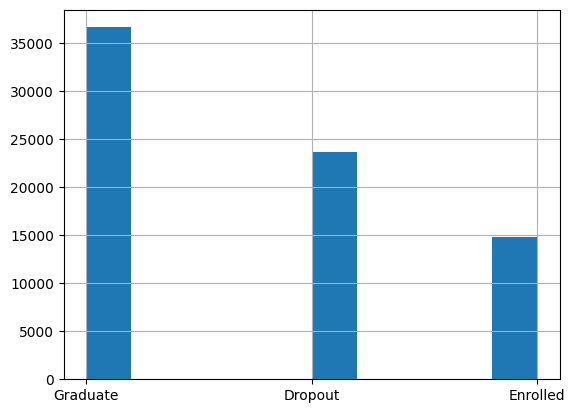

In [5]:
df['Target'].value_counts(), df['Target'].hist()

So we have an imbalanced dataset. To handle this - for classical ML models, we oversample the smaller classes

In [6]:
# Train test split
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y_l = le.fit(y)
y_enc = y_l.transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size=0.2, random_state=42)

### Decision tree

First we check the performance without any oversampling

In [7]:
from sklearn import tree

In [8]:
%%time
model_dt = tree.DecisionTreeClassifier()
start = time.perf_counter()
model_dt.fit(X_train,y_train)
end = time.perf_counter()

CPU times: total: 500 ms
Wall time: 1.07 s


In [9]:
y_pred = model_dt.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9368,   937],
        [  775,  3924]],

       [[10576,  1467],
        [ 1449,  1512]],

       [[ 6492,  1168],
        [ 1348,  5996]]], dtype=int64)

In [10]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.720719463793155, 0.7619301519594774)

In [11]:
print('DECISION TREE - NO PREPROCESSING')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Decision_tree_no_preprocessing', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

DECISION TREE - NO PREPROCESSING


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8072413083727628, 'recal...",1.066185


Next, let us use `SMOTE` (Synthetic Minority Over-sampling Technique) to oversample the minority classes

In [12]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [13]:
#Apply Over Sampling
print(f'Before Oversampling {sorted(Counter(y_train).items())}')
X_train1, y_train1 = SMOTE().fit_resample(X_train, y_train)
print(f'After Oversampling {sorted(Counter(y_train1).items())}')

Before Oversampling [(0, 18970), (1, 11785), (2, 29259)]
After Oversampling [(0, 29259), (1, 29259), (2, 29259)]


In [14]:
%%time
model_dt = tree.DecisionTreeClassifier()
start = time.perf_counter()
model_dt.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 5.05 s
Wall time: 5.18 s


In [15]:
y_pred = model_dt.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9440,   865],
        [  778,  3921]],

       [[10546,  1497],
        [ 1389,  1572]],

       [[ 6475,  1185],
        [ 1380,  5964]]], dtype=int64)

In [16]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7258086945713211, 0.7635963743001866)

In [17]:
print('DECISION TREE - SMOTE')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Decision_tree_oversampling', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

DECISION TREE - SMOTE


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8072413083727628, 'recal...",1.066185
1,Decision_tree_oversampling,"{'0': {'precision': 0.8192645215211032, 'recal...",5.181477


Let us try an undersampler

In [18]:
from imblearn.under_sampling import RandomUnderSampler

In [19]:
#Apply Random Under Sampling
rus = RandomUnderSampler(random_state=0)
print(f'Before Undersampling {sorted(Counter(y_train).items())}')
X_train1, y_train1 =rus.fit_resample(X_train, y_train)
print(f'After Undersampling {sorted(Counter(y_train1).items())}')

Before Undersampling [(0, 18970), (1, 11785), (2, 29259)]
After Undersampling [(0, 11785), (1, 11785), (2, 11785)]


In [20]:
%%time
model_dt = tree.DecisionTreeClassifier()
start = time.perf_counter()
model_dt.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 1.16 s
Wall time: 1.28 s


In [21]:
y_pred = model_dt.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[9401,  904],
        [ 834, 3865]],

       [[9832, 2211],
        [1071, 1890]],

       [[6818,  842],
        [2052, 5292]]], dtype=int64)

In [22]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7271338454830616, 0.7362703279125566)

In [23]:
print('DECISION TREE - Random Undersampler')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Decision_tree_undersampling', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

DECISION TREE - Random Undersampler


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8072413083727628, 'recal...",1.066185
1,Decision_tree_oversampling,"{'0': {'precision': 0.8192645215211032, 'recal...",5.181477
2,Decision_tree_undersampling,"{'0': {'precision': 0.8104424407632628, 'recal...",1.281096


So, the performance is not vastly affected by the oversampling or undersampling => Decision tree is robust to imbalanced data

### Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
estims = [5,10,20,50,100,200,300]
model = RandomForestClassifier()
acc,tim = [], []
for x in estims:
    model = RandomForestClassifier(n_estimators=x,warm_start=True)
    start = time.perf_counter()
    model.fit(X_train,y_train)
    end = time.perf_counter()
    y_pred = model.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estimators: {x}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_estimators: 5, time_taken: 1.4639389999210835s, accuracy: 0.7995867768595041
n_estimators: 10, time_taken: 2.986446099821478s, accuracy: 0.8139829378832312
n_estimators: 20, time_taken: 5.413364399923012s, accuracy: 0.8267795254598773
n_estimators: 50, time_taken: 13.187157700071111s, accuracy: 0.8314449480138629
n_estimators: 100, time_taken: 14.697851500008255s, accuracy: 0.8345107971207678
n_estimators: 200, time_taken: 26.815963699948043s, accuracy: 0.8365769128232471
n_estimators: 300, time_taken: 47.31647190009244s, accuracy: 0.8353105838443082


Pick best model

In [26]:
model1 = RandomForestClassifier(n_estimators=estims[np.argmax(acc)],warm_start=True)
start = time.perf_counter()
model1.fit(X_train,y_train)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {x}, time_taken: {end-start}s, accuracy: {_acc}')

n_estimators: 300, time_taken: 36.3925775999669s, accuracy: 0.834910690482538


In [27]:
model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(n_estimators=300, warm_start=True)>

In [28]:
y_pred = model.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'RandomForest_no_preprocessing', 'metrics': x, 'training_time(s)': tim[-1]})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8072413083727628, 'recal...",1.066185
1,Decision_tree_oversampling,"{'0': {'precision': 0.8192645215211032, 'recal...",5.181477
2,Decision_tree_undersampling,"{'0': {'precision': 0.8104424407632628, 'recal...",1.281096
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.946270853778214, 'recall...",47.316472


Text(0.5, 1.0, 'Training time')

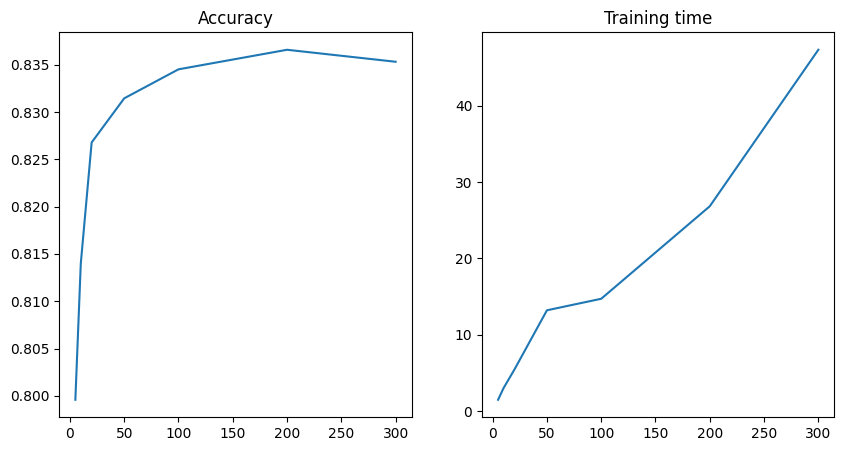

In [29]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(estims,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(estims,tim)
ax2.set_title('Training time')

Try with SMOTE

In [30]:
X_train1, y_train1 = SMOTE().fit_resample(X_train,y_train)
estims = [5,10,20,50,100,200,300]
model = RandomForestClassifier()
acc,tim = [], []
for x in estims:
    model = RandomForestClassifier(n_estimators=x,warm_start=True)
    start = time.perf_counter()
    model.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estimators: {x}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_estimators: 5, time_taken: 2.297044500010088s, accuracy: 0.7995867768595041
n_estimators: 10, time_taken: 3.569596700137481s, accuracy: 0.8180485203945614
n_estimators: 20, time_taken: 8.607535799965262s, accuracy: 0.8261796854172221
n_estimators: 50, time_taken: 20.697533099912107s, accuracy: 0.8317781924820048
n_estimators: 100, time_taken: 72.84697670000605s, accuracy: 0.8329778725673154
n_estimators: 200, time_taken: 111.21241220016964s, accuracy: 0.8335110637163423
n_estimators: 300, time_taken: 134.349898400018s, accuracy: 0.8332444681418288


Pick best model

In [31]:
model1 = RandomForestClassifier(n_estimators=estims[np.argmax(acc)],warm_start=True)
start = time.perf_counter()
model1.fit(X_train1,y_train1)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {estims[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')

n_estimators: 200, time_taken: 109.96131150005385s, accuracy: 0.8330445214609438


In [32]:
model.feature_importances_

array([0.00086687, 0.00875009, 0.00759882, 0.01183261, 0.00069221,
       0.00169284, 0.02044773, 0.01157121, 0.01150637, 0.01201701,
       0.02299017, 0.00656748, 0.00043072, 0.00495055, 0.0188556 ,
       0.01173874, 0.0241558 , 0.01618498, 0.00175634, 0.00909079,
       0.03621919, 0.08947201, 0.06250715, 0.00150443, 0.00156258,
       0.01112991, 0.04685576, 0.15013224, 0.10966183, 0.00160883,
       0.01345917, 0.0124258 , 0.01455473, 0.00083398, 0.00767959,
       0.01204089, 0.0007341 , 0.00187524, 0.01215713, 0.00040685,
       0.00593324, 0.02142406, 0.02065922, 0.0173091 , 0.00185013,
       0.05668794, 0.00155467, 0.00161082, 0.08083716, 0.00161534])

In [33]:
y_pred = model.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'RandomForest_oversampling', 'metrics': x, 'training_time(s)': tim[-1]})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8072413083727628, 'recal...",1.066185
1,Decision_tree_oversampling,"{'0': {'precision': 0.8192645215211032, 'recal...",5.181477
2,Decision_tree_undersampling,"{'0': {'precision': 0.8104424407632628, 'recal...",1.281096
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.946270853778214, 'recall...",47.316472
4,RandomForest_oversampling,"{'0': {'precision': 0.9532687049465572, 'recal...",134.349898


Text(0.5, 1.0, 'Training time')

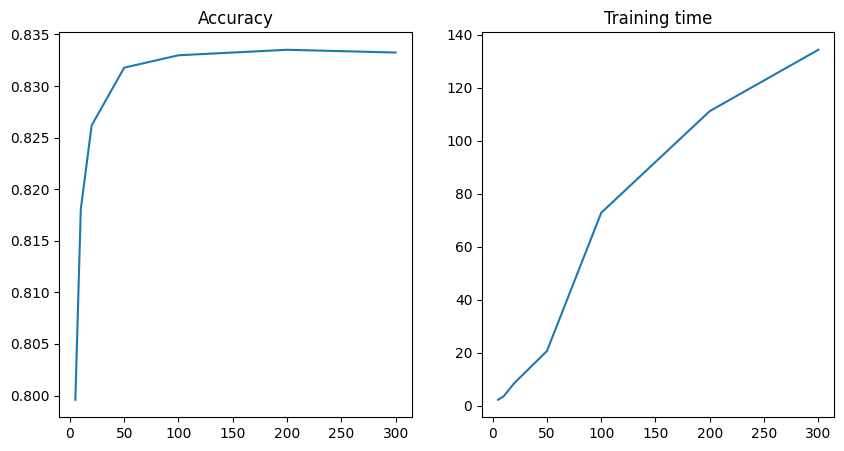

In [34]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(estims,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(estims,tim)
ax2.set_title('Training time')


Let's try Undersampling

In [35]:
X_train1, y_train1 = RandomUnderSampler().fit_resample(X_train,y_train)
estims = [5,10,20,50,100,200,300]
model = RandomForestClassifier()
acc,tim = [], []
for x in estims:
    model = RandomForestClassifier(n_estimators=x,warm_start=True)
    start = time.perf_counter()
    model.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estimators: {x}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_estimators: 5, time_taken: 0.8623602001462132s, accuracy: 0.7754598773660357
n_estimators: 10, time_taken: 1.6096657998859882s, accuracy: 0.7910557184750733
n_estimators: 20, time_taken: 3.5772107001394033s, accuracy: 0.8039189549453479
n_estimators: 50, time_taken: 6.019068199908361s, accuracy: 0.8121167688616369
n_estimators: 100, time_taken: 8.261339199962094s, accuracy: 0.8135163956278326
n_estimators: 200, time_taken: 29.962966099847108s, accuracy: 0.8148493735003999
n_estimators: 300, time_taken: 32.30679100006819s, accuracy: 0.8173153825646494


Pick best model

In [36]:
model1 = RandomForestClassifier(n_estimators=estims[np.argmax(acc)],warm_start=True)
start = time.perf_counter()
model1.fit(X_train1,y_train1)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {estims[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')

n_estimators: 300, time_taken: 24.874332499923185s, accuracy: 0.8168488403092509


In [37]:
model.feature_importances_

array([0.00082644, 0.01193799, 0.00857145, 0.01604411, 0.00107902,
       0.00223376, 0.02731321, 0.01445519, 0.01445587, 0.01463447,
       0.03252089, 0.00581013, 0.00037   , 0.00423123, 0.01681652,
       0.00692605, 0.0122623 , 0.01927631, 0.00199534, 0.00979924,
       0.03472746, 0.08250975, 0.0869888 , 0.001596  , 0.00155632,
       0.00985803, 0.04481059, 0.11473117, 0.11111618, 0.0016972 ,
       0.01617353, 0.01437229, 0.01661194, 0.0008122 , 0.00852519,
       0.01584951, 0.00104561, 0.00219135, 0.01438968, 0.00038324,
       0.00393679, 0.01685159, 0.01278002, 0.01839015, 0.00191932,
       0.05938283, 0.00160635, 0.00159162, 0.08034073, 0.00169508])

In [38]:
y_pred = model.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'RandomForest_undersampling', 'metrics': x, 'training_time(s)': tim[-1]})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8072413083727628, 'recal...",1.066185
1,Decision_tree_oversampling,"{'0': {'precision': 0.8192645215211032, 'recal...",5.181477
2,Decision_tree_undersampling,"{'0': {'precision': 0.8104424407632628, 'recal...",1.281096
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.946270853778214, 'recall...",47.316472
4,RandomForest_oversampling,"{'0': {'precision': 0.9532687049465572, 'recal...",134.349898
5,RandomForest_undersampling,"{'0': {'precision': 0.9706874189364462, 'recal...",32.306791


Text(0.5, 1.0, 'Training time')

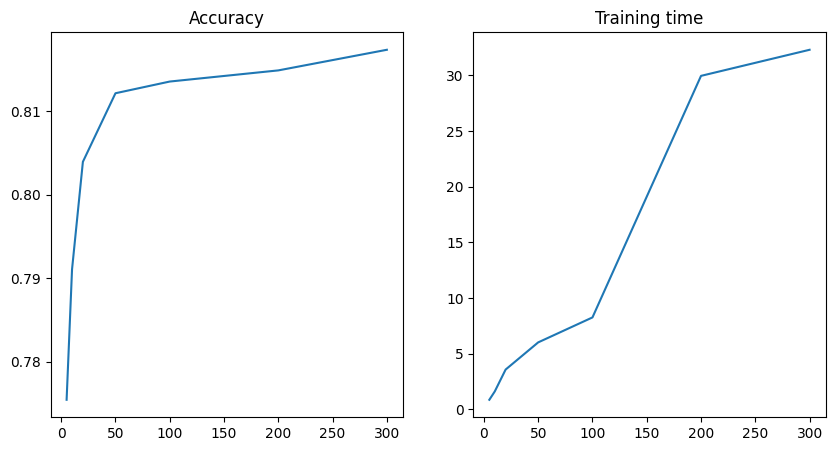

In [39]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(estims,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(estims,tim)
ax2.set_title('Training time')


### Naive Bayes

In [40]:
from sklearn.naive_bayes import GaussianNB

In [41]:
%%time
model_nb = GaussianNB()
start = time.perf_counter()
model_nb.fit(X_train, y_train)
end = time.perf_counter()

CPU times: total: 62.5 ms
Wall time: 93.1 ms


In [42]:
y_pred = model_nb.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9667,   638],
        [ 1001,  3698]],

       [[10821,  1222],
        [ 1635,  1326]],

       [[ 5905,  1755],
        [  979,  6365]]], dtype=int64)

In [43]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7004971779922178, 0.7590642495334577)

In [44]:
print('NAIVE BAYES - No preprocessing')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Naive_Bayes_no_preprocessing', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

NAIVE BAYES - No preprocessing


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8072413083727628, 'recal...",1.066185
1,Decision_tree_oversampling,"{'0': {'precision': 0.8192645215211032, 'recal...",5.181477
2,Decision_tree_undersampling,"{'0': {'precision': 0.8104424407632628, 'recal...",1.281096
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.946270853778214, 'recall...",47.316472
4,RandomForest_oversampling,"{'0': {'precision': 0.9532687049465572, 'recal...",134.349898
5,RandomForest_undersampling,"{'0': {'precision': 0.9706874189364462, 'recal...",32.306791
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.093065


Let's try oversampling 

In [45]:
X_train1, y_train1 = SMOTE().fit_resample(X_train, y_train)

In [46]:
%%time
model_nb = GaussianNB()
start = time.perf_counter()
model_nb.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 281 ms
Wall time: 101 ms


In [47]:
y_pred = model_nb.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9623,   682],
        [  986,  3713]],

       [[10399,  1644],
        [ 1226,  1735]],

       [[ 6444,  1216],
        [ 1330,  6014]]], dtype=int64)

In [48]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7316728651151765, 0.7639296187683284)

In [49]:
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'Naive_Bayes_oversampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8072413083727628, 'recal...",1.066185
1,Decision_tree_oversampling,"{'0': {'precision': 0.8192645215211032, 'recal...",5.181477
2,Decision_tree_undersampling,"{'0': {'precision': 0.8104424407632628, 'recal...",1.281096
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.946270853778214, 'recall...",47.316472
4,RandomForest_oversampling,"{'0': {'precision': 0.9532687049465572, 'recal...",134.349898
5,RandomForest_undersampling,"{'0': {'precision': 0.9706874189364462, 'recal...",32.306791
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.093065
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8448236632536974, 'recal...",0.101237


Let's try undersampling

In [50]:
X_train1, y_train1 = RandomUnderSampler().fit_resample(X_train, y_train)

In [51]:
%%time
model_nb = GaussianNB()
start = time.perf_counter()
model_nb.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 0 ns
Wall time: 36.8 ms


In [52]:
y_pred = model_nb.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9664,   641],
        [ 1004,  3695]],

       [[10726,  1317],
        [ 1534,  1427]],

       [[ 6032,  1628],
        [ 1048,  6296]]], dtype=int64)

In [53]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7085225911235457, 0.7609970674486803)

In [54]:
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'Naive_Bayes_undersampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8072413083727628, 'recal...",1.066185
1,Decision_tree_oversampling,"{'0': {'precision': 0.8192645215211032, 'recal...",5.181477
2,Decision_tree_undersampling,"{'0': {'precision': 0.8104424407632628, 'recal...",1.281096
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.946270853778214, 'recall...",47.316472
4,RandomForest_oversampling,"{'0': {'precision': 0.9532687049465572, 'recal...",134.349898
5,RandomForest_undersampling,"{'0': {'precision': 0.9706874189364462, 'recal...",32.306791
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.093065
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8448236632536974, 'recal...",0.101237
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8521678966789668, 'recal...",0.037619


### K Nearest Neighbors

In [60]:
from sklearn.neighbors import KNeighborsClassifier

In [61]:
nbors = [3,5,10,15,20,25,50,100,200,400,800]
tim, acc = [], []
model_knn = KNeighborsClassifier()

for n in nbors:
    model_knn = KNeighborsClassifier(n_neighbors=n)
    start = time.perf_counter()
    model_knn.fit(X_train,y_train)
    end = time.perf_counter()
    y_pred = model_knn.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_neighbors: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_neighbors: 3, time_taken: 0.013904700055718422s, accuracy: 0.7342042122100774
n_neighbors: 5, time_taken: 0.01322800014168024s, accuracy: 0.7457344708077845
n_neighbors: 10, time_taken: 0.00706010009162128s, accuracy: 0.753998933617702
n_neighbors: 15, time_taken: 0.006334200035780668s, accuracy: 0.753998933617702
n_neighbors: 20, time_taken: 0.007885999977588654s, accuracy: 0.7530658491069048
n_neighbors: 25, time_taken: 0.01021880004554987s, accuracy: 0.751266328978939
n_neighbors: 50, time_taken: 0.009707899997010827s, accuracy: 0.7434684084244202
n_neighbors: 100, time_taken: 0.006164100021123886s, accuracy: 0.7292055451879499
n_neighbors: 200, time_taken: 0.00973709998652339s, accuracy: 0.7113436416955479
n_neighbors: 400, time_taken: 0.00720779993571341s, accuracy: 0.6866169021594242
n_neighbors: 800, time_taken: 0.008246499812230468s, accuracy: 0.6582244734737404


Pick best model

In [62]:
model1 = KNeighborsClassifier(n_neighbors=nbors[np.argmax(acc)])
start = time.perf_counter()
model1.fit(X_train,y_train)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {nbors[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')
model1.get_params

n_estimators: 10, time_taken: 0.01371240010485053s, accuracy: 0.753998933617702


<bound method BaseEstimator.get_params of KNeighborsClassifier(n_neighbors=10)>

In [63]:
y_pred = model1.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'KNN_no_preprocessing', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8072413083727628, 'recal...",1.066185
1,Decision_tree_oversampling,"{'0': {'precision': 0.8192645215211032, 'recal...",5.181477
2,Decision_tree_undersampling,"{'0': {'precision': 0.8104424407632628, 'recal...",1.281096
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.946270853778214, 'recall...",47.316472
4,RandomForest_oversampling,"{'0': {'precision': 0.9532687049465572, 'recal...",134.349898
5,RandomForest_undersampling,"{'0': {'precision': 0.9706874189364462, 'recal...",32.306791
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.093065
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8448236632536974, 'recal...",0.101237
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8521678966789668, 'recal...",0.037619
9,KNN_no_preprocessing,"{'0': {'precision': 0.8735545500251383, 'recal...",0.013712


Text(0.5, 1.0, 'Training time')

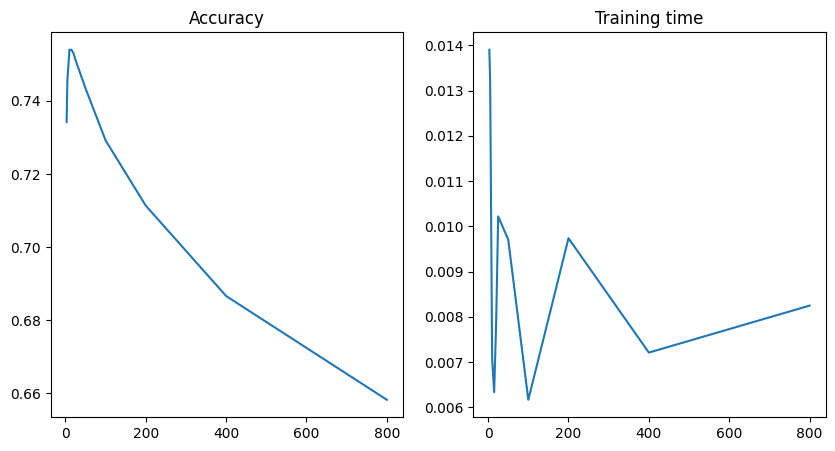

In [64]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(nbors,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(nbors,tim)
ax2.set_title('Training time')

Let's try oversampling

In [65]:
X_train1, y_train1 = SMOTE().fit_resample(X_train,y_train)

In [66]:
nbors = [3,5,10,15,20,25,50,100,200,400,800]
tim, acc = [], []
model_knn = KNeighborsClassifier()

for n in nbors:
    model_knn = KNeighborsClassifier(n_neighbors=n)
    start = time.perf_counter()
    model_knn.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model_knn.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_neighbors: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_neighbors: 3, time_taken: 0.015507099917158484s, accuracy: 0.7003465742468675
n_neighbors: 5, time_taken: 0.011253400007262826s, accuracy: 0.6988802985870435
n_neighbors: 10, time_taken: 0.013427500147372484s, accuracy: 0.6996800853105839
n_neighbors: 15, time_taken: 0.010580000001937151s, accuracy: 0.7080111970141295
n_neighbors: 20, time_taken: 0.01119489991106093s, accuracy: 0.7037456678219142
n_neighbors: 25, time_taken: 0.018301700009033084s, accuracy: 0.7042788589709411
n_neighbors: 50, time_taken: 0.015107800019904971s, accuracy: 0.7008797653958945
n_neighbors: 100, time_taken: 0.015287899877876043s, accuracy: 0.6899493468408424
n_neighbors: 200, time_taken: 0.012987200170755386s, accuracy: 0.6797520661157025
n_neighbors: 400, time_taken: 0.007760399952530861s, accuracy: 0.6664889362836577
n_neighbors: 800, time_taken: 0.011216599959880114s, accuracy: 0.64396161023727


Pick best model

In [67]:
model1 = KNeighborsClassifier(n_neighbors=nbors[np.argmax(acc)])
start = time.perf_counter()
model1.fit(X_train1,y_train1)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {nbors[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')
model1.get_params

n_estimators: 15, time_taken: 0.014597899978980422s, accuracy: 0.7080111970141295


<bound method BaseEstimator.get_params of KNeighborsClassifier(n_neighbors=15)>

In [68]:
y_pred = model1.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'KNN_oversampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8072413083727628, 'recal...",1.066185
1,Decision_tree_oversampling,"{'0': {'precision': 0.8192645215211032, 'recal...",5.181477
2,Decision_tree_undersampling,"{'0': {'precision': 0.8104424407632628, 'recal...",1.281096
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.946270853778214, 'recall...",47.316472
4,RandomForest_oversampling,"{'0': {'precision': 0.9532687049465572, 'recal...",134.349898
5,RandomForest_undersampling,"{'0': {'precision': 0.9706874189364462, 'recal...",32.306791
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.093065
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8448236632536974, 'recal...",0.101237
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8521678966789668, 'recal...",0.037619
9,KNN_no_preprocessing,"{'0': {'precision': 0.8735545500251383, 'recal...",0.013712


Text(0.5, 1.0, 'Training time')

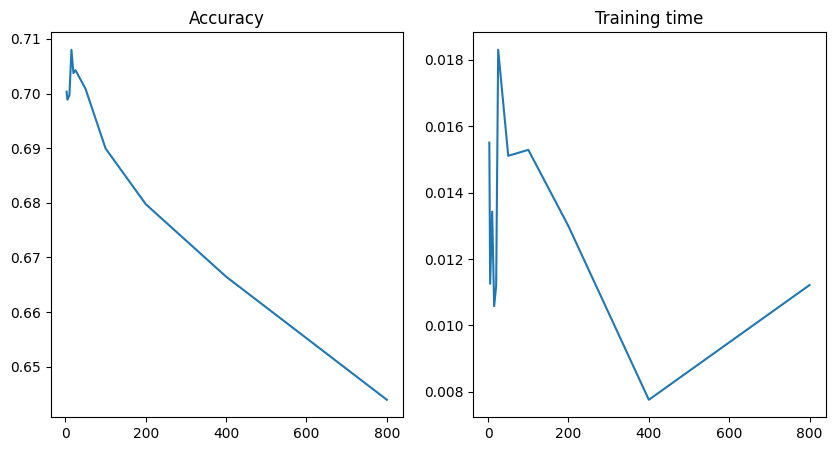

In [69]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(nbors,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(nbors,tim)
ax2.set_title('Training time')

Let's try undersampling

In [70]:
X_train1, y_train1 = RandomUnderSampler().fit_resample(X_train,y_train)

In [71]:
nbors = [3,5,10,15,20,25,50,100,200,400,800]
tim, acc = [], []
model_knn = KNeighborsClassifier()

for n in nbors:
    model_knn = KNeighborsClassifier(n_neighbors=n)
    start = time.perf_counter()
    model_knn.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model_knn.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_neighbors: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_neighbors: 3, time_taken: 0.004091599956154823s, accuracy: 0.694614769394828
n_neighbors: 5, time_taken: 0.0037070000544190407s, accuracy: 0.7042122100773127
n_neighbors: 10, time_taken: 0.004570400109514594s, accuracy: 0.7076779525459878
n_neighbors: 15, time_taken: 0.003762299893423915s, accuracy: 0.7122100773127166
n_neighbors: 20, time_taken: 0.004290600074455142s, accuracy: 0.7063449746734204
n_neighbors: 25, time_taken: 0.013324700063094497s, accuracy: 0.7012796587576646
n_neighbors: 50, time_taken: 0.010493299923837185s, accuracy: 0.691882164756065
n_neighbors: 100, time_taken: 0.0027974999975413084s, accuracy: 0.6758197813916289
n_neighbors: 200, time_taken: 0.0038542000111192465s, accuracy: 0.6633564382831245
n_neighbors: 400, time_taken: 0.0028568999841809273s, accuracy: 0.6344308184484138
n_neighbors: 800, time_taken: 0.0035869998391717672s, accuracy: 0.608770994401493


Pick best model

In [72]:
model1 = KNeighborsClassifier(n_neighbors=nbors[np.argmax(acc)])
start = time.perf_counter()
model1.fit(X_train1,y_train1)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {nbors[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')
model1.get_params

n_estimators: 15, time_taken: 0.009641699958592653s, accuracy: 0.7122100773127166


<bound method BaseEstimator.get_params of KNeighborsClassifier(n_neighbors=15)>

In [73]:
y_pred = model1.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'KNN_undersampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8072413083727628, 'recal...",1.066185
1,Decision_tree_oversampling,"{'0': {'precision': 0.8192645215211032, 'recal...",5.181477
2,Decision_tree_undersampling,"{'0': {'precision': 0.8104424407632628, 'recal...",1.281096
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.946270853778214, 'recall...",47.316472
4,RandomForest_oversampling,"{'0': {'precision': 0.9532687049465572, 'recal...",134.349898
5,RandomForest_undersampling,"{'0': {'precision': 0.9706874189364462, 'recal...",32.306791
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.852859778597786, 'recall...",0.093065
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8448236632536974, 'recal...",0.101237
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8521678966789668, 'recal...",0.037619
9,KNN_no_preprocessing,"{'0': {'precision': 0.8735545500251383, 'recal...",0.013712


Text(0.5, 1.0, 'Training time')

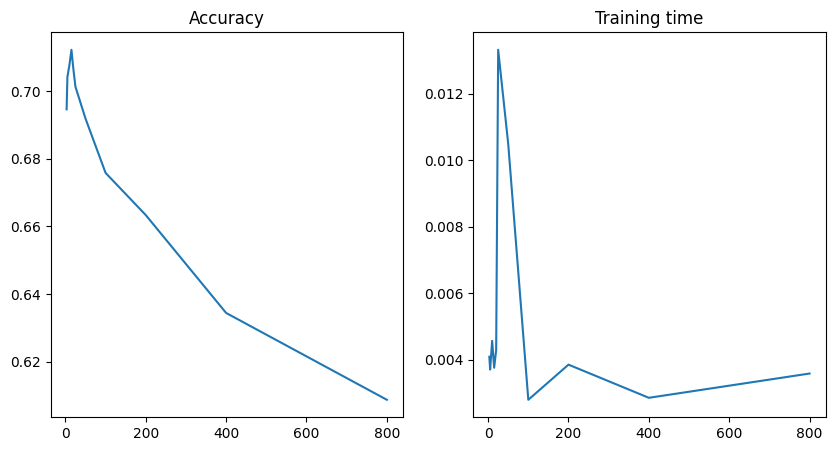

In [74]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(nbors,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(nbors,tim)
ax2.set_title('Training time')

In [75]:
df_results = pd.DataFrame(models)

In [76]:
df_results['precision'] = df_results['metrics'].apply(lambda x: {0: round(x['0']['precision'],3), 1: round(x['1']['precision'],3), 2: round(x['2']['precision'],3)})
df_results['recall'] = df_results['metrics'].apply(lambda x: {0: round(x['0']['recall'],3), 1: round(x['1']['recall'],3), 2: round(x['2']['recall'],3)})
df_results['f1-score'] = df_results['metrics'].apply(lambda x: {0: round(x['0']['f1-score'],3), 1: round(x['1']['f1-score'],3), 2: round(x['2']['f1-score'],3)})
df_results['macro_avg'] = df_results['metrics'].apply(lambda x: {k: round(x['macro avg'][k],3) for k in x['macro avg'].keys()})
df_results['weighted_avg'] = df_results['metrics'].apply(lambda x: {k: round(x['weighted avg'][k],3) for k in x['weighted avg'].keys()})
df_results['accuracy'] = df_results['metrics'].apply(lambda x: round(x['accuracy'],3))
df_results['time (s)'] = df_results['training_time(s)']
df_results.drop(columns=['metrics','training_time(s)'],inplace=True)

In [77]:
df_results.to_csv('data/benchmarking_outliers_handled.csv',index=False)
df_results

,model,precision,recall,f1-score,macro_avg,weighted_avg,accuracy,time (s)
0,Decision_tree_no_preprocessing,"{0: 0.807, 1: 0.508, 2: 0.837}","{0: 0.835, 1: 0.511, 2: 0.816}","{0: 0.821, 1: 0.509, 2: 0.827}","{'precision': 0.717, 'recall': 0.721, 'f1-scor...","{'precision': 0.763, 'recall': 0.762, 'f1-scor...",0.762,1.066185
1,Decision_tree_oversampling,"{0: 0.819, 1: 0.512, 2: 0.834}","{0: 0.834, 1: 0.531, 2: 0.812}","{0: 0.827, 1: 0.521, 2: 0.823}","{'precision': 0.722, 'recall': 0.726, 'f1-scor...","{'precision': 0.766, 'recall': 0.764, 'f1-scor...",0.764,5.181477
2,Decision_tree_undersampling,"{0: 0.81, 1: 0.461, 2: 0.863}","{0: 0.823, 1: 0.638, 2: 0.721}","{0: 0.816, 1: 0.535, 2: 0.785}","{'precision': 0.711, 'recall': 0.727, 'f1-scor...","{'precision': 0.767, 'recall': 0.736, 'f1-scor...",0.736,1.281096
3,RandomForest_no_preprocessing,"{0: 0.946, 1: 0.646, 2: 0.847}","{0: 0.821, 1: 0.632, 2: 0.927}","{0: 0.879, 1: 0.639, 2: 0.885}","{'precision': 0.813, 'recall': 0.793, 'f1-scor...","{'precision': 0.839, 'recall': 0.835, 'f1-scor...",0.835,47.316472
4,RandomForest_oversampling,"{0: 0.953, 1: 0.625, 2: 0.856}","{0: 0.816, 1: 0.669, 2: 0.911}","{0: 0.879, 1: 0.646, 2: 0.882}","{'precision': 0.811, 'recall': 0.798, 'f1-scor...","{'precision': 0.841, 'recall': 0.833, 'f1-scor...",0.833,134.349898
5,RandomForest_undersampling,"{0: 0.971, 1: 0.557, 2: 0.892}","{0: 0.796, 1: 0.8, 2: 0.838}","{0: 0.875, 1: 0.657, 2: 0.864}","{'precision': 0.807, 'recall': 0.811, 'f1-scor...","{'precision': 0.851, 'recall': 0.817, 'f1-scor...",0.817,32.306791
6,Naive_Bayes_no_preprocessing,"{0: 0.853, 1: 0.52, 2: 0.784}","{0: 0.787, 1: 0.448, 2: 0.867}","{0: 0.819, 1: 0.481, 2: 0.823}","{'precision': 0.719, 'recall': 0.7, 'f1-score'...","{'precision': 0.753, 'recall': 0.759, 'f1-scor...",0.759,0.093065
7,Naive_Bayes_oversampling,"{0: 0.845, 1: 0.513, 2: 0.832}","{0: 0.79, 1: 0.586, 2: 0.819}","{0: 0.817, 1: 0.547, 2: 0.825}","{'precision': 0.73, 'recall': 0.732, 'f1-score...","{'precision': 0.773, 'recall': 0.764, 'f1-scor...",0.764,0.101237
8,Naive_Bayes_undersampling,"{0: 0.852, 1: 0.52, 2: 0.795}","{0: 0.786, 1: 0.482, 2: 0.857}","{0: 0.818, 1: 0.5, 2: 0.825}","{'precision': 0.722, 'recall': 0.709, 'f1-scor...","{'precision': 0.758, 'recall': 0.761, 'f1-scor...",0.761,0.037619
9,KNN_no_preprocessing,"{0: 0.874, 1: 0.525, 2: 0.768}","{0: 0.74, 1: 0.457, 2: 0.883}","{0: 0.801, 1: 0.488, 2: 0.821}","{'precision': 0.722, 'recall': 0.693, 'f1-scor...","{'precision': 0.753, 'recall': 0.754, 'f1-scor...",0.754,0.013712
